## This notebook provides validation precision of expressions recognition trained resnet18 and resnet34 

In [2]:
import torch.nn.functional as F
from torch import cuda
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
import time
import math
import os
import random
import cv2
import PIL
import pandas
from os.path import join
import copy
import timm 
from collections import OrderedDict
from numpy.linalg import norm as l2norm
import sys

## Below is the function which computes expression logits for each image given model 

In [2]:
sys.path.append('/storage_labs/3030/BelyakovM/Face_attributes/insightface/recognition/arcface_torch')
from backbones import get_model
net = get_model('r18', fp16=False)
net.load_state_dict(torch.load('/storage_labs/3030/BelyakovM/Face_attributes/insightface/recognition/arcface_torch/work_dirs/AffectnetOzon_r18_attempt4/backbone_38.pth'))
@torch.no_grad()
def inference(net, img):
    if img is None:
        img = np.random.randint(0, 255, size=(112, 112, 3), dtype=np.uint8)
    else:
        img = cv2.imread(img)
        img = cv2.resize(img, (112, 112))

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.transpose(img, (2, 0, 1))
    img = torch.from_numpy(img).unsqueeze(0).float()
    img.div_(255).sub_(0.5).div_(0.5)
 
    net.eval()
    feat = net(img).numpy()
    return feat

## Let's visualize expression reference images

Reference list #1
anger reference:


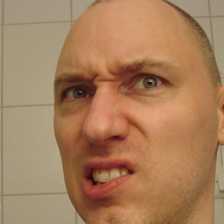

disgust reference:


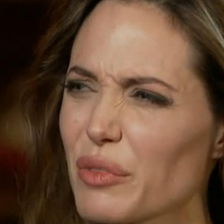

fear reference:


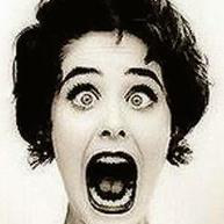

happiness reference:


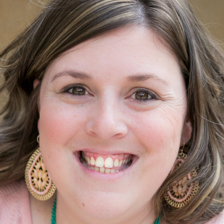

neutral reference:


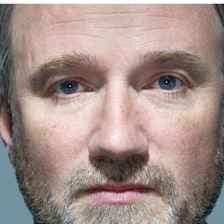

sadness reference:


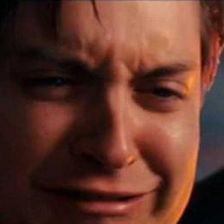

surprise reference:


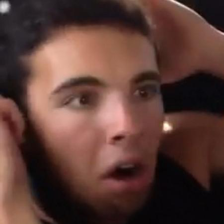

Reference list #2
anger reference:


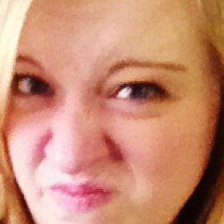

disgust reference:


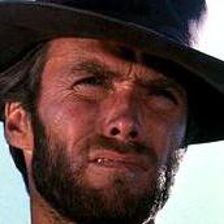

fear reference:


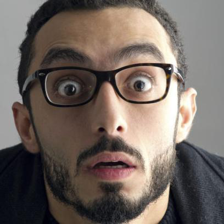

happiness reference:


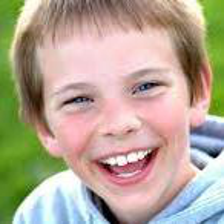

neutral reference:


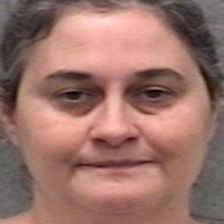

sadness reference:


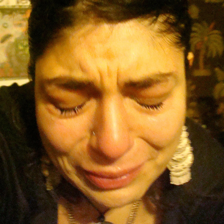

surprise reference:


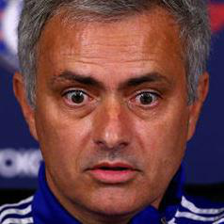

Reference list #3
anger reference:


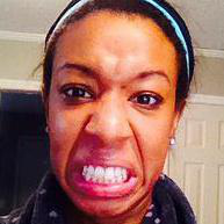

disgust reference:


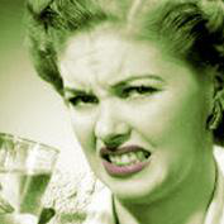

fear reference:


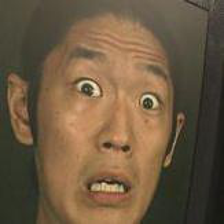

happiness reference:


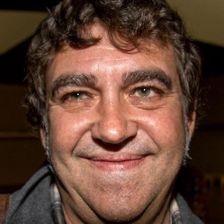

neutral reference:


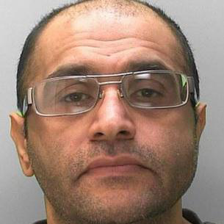

sadness reference:


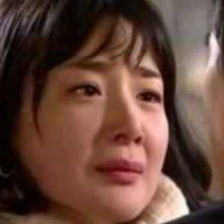

surprise reference:


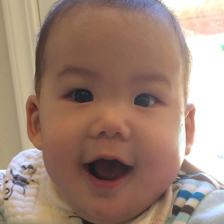

In [11]:
anger = ['anger','Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/test_kaggle/93.jpg',
        'Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/test_kaggle/109.jpg',
         'Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/test_kaggle/121.jpg']
disgust = ['disgust','Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/train/disgust/31.jpg',
           'Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/train/disgust/45.jpg',
           'Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/train/disgust/57.jpg']
fear = ['fear','Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/train/fear/22.jpg',
        'Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/train/fear/64.jpg',
        'Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/train/fear/74.jpg']
happiness = ['happiness','Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/train/happy/3326.jpg',
             'Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/train/happy/3335.jpg',
             'Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/train/happy/3418.jpg']
neutral = ['neutral','Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/train/neutral/168.jpg',
          'Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/train/neutral/169.jpg',
          'Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/train/neutral/193.jpg']
sadness = ['sadness','Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/train/sad/3808.jpg',
          'Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/train/sad/3840.jpg',
          'Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/train/sad/3961.jpg']
surprise = ['surprise','Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/train/surprise/3195.jpg',
           'Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/train/surprise/3205.jpg',
            'Face_attributes/ds/db_BuevichP/emochon/OZON_expressions_dataset/train/surprise/3242.jpg']
reference = [anger,disgust,fear,happiness,neutral,sadness,surprise]
reference.sort()

for i in range(1,4):
    print('Reference list #{}'.format(i))
    for expression in reference:
        print('{} reference:'.format(expression[0]))
        img = default_loader('/storage_labs/3030/BelyakovM/'+expression[i])
        img = img.resize((224,224))
        img.show()
        
        

## Below is the section where model expressions precision is evaluated on various val sets. Each val set precision is computed with 3 different reference sets

In [6]:
#Computing r18 validation accuracy on AffectNet/val set with external references 
datadir = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/AffecetNet_partly/original/val'
for i in range(1,4):
    expression_reference_logits=[]
    for expression_list in reference:
        logits_reference = inference(net,'/storage_labs/3030/BelyakovM/'+expression_list[i])
        logits_reference = np.mean(logits_reference, axis=0)
        logits_reference /= l2norm(logits_reference)
        expression_reference_logits.append((expression_list[0],logits_reference))
    folder_acc=[]
    for folder in os.listdir(datadir):
        folder_corrects = 0
        imgs = os.listdir(os.path.join(datadir,folder))
        num_folder_imgs = len(imgs)
        for image in imgs:
            try:
                logits_val_img = inference(net,os.path.join(datadir,folder,image))
                logits_val_img = np.mean(logits_val_img, axis=0)
                logits_val_img /= l2norm(logits_val_img)
            except:
                num_folder_imgs -= 1
                continue
            expression_reference_scores=[]
   
            for logits in expression_reference_logits:
                score = np.dot(logits_val_img,logits[1])
                expression_reference_scores.append(score)
                
            max_score = max(expression_reference_scores)
            if folder == reference[expression_reference_scores.index(max_score)][0]:
                folder_corrects += 1
        folder_acc.append((folder,folder_corrects/num_folder_imgs))
    print(folder_acc)

[('anger', 0.092), ('sadness', 0.706), ('fear', 0.828), ('happiness', 0.838), ('surprise', 0.67), ('disgust', 0.346), ('neutral', 0.588)]
[('anger', 0.006), ('sadness', 0.676), ('fear', 0.854), ('happiness', 0.8), ('surprise', 0.7), ('disgust', 0.768), ('neutral', 0.618)]
[('anger', 0.428), ('sadness', 0.646), ('fear', 0.858), ('happiness', 0.804), ('surprise', 0.692), ('disgust', 0.394), ('neutral', 0.58)]


In [27]:
#Computing r18 validation accuracy on FACESds with external references 
datadir = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds'
annotation_path = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds/annotation.txt'
reference_list = reference.copy()
_ = reference_list.pop(6)
file_to_read = open(annotation_path,'r')
annotation_list = [line.split(';') for line in file_to_read.readlines()]
for i in range(1,4):
    expression_reference_logits=[]
    
    for expression_list in reference_list:
        logits_reference = inference(net,'/storage_labs/3030/BelyakovM/'+expression_list[i])
        logits_reference = np.mean(logits_reference, axis=0)
        logits_reference /= l2norm(logits_reference)
        expression_reference_logits.append((expression_list[0],logits_reference))
    folder_acc=[]
    overall_corrects = {'anger':0,'sadness':0,'fear':0,'happiness':0,'disgust':0,'neutral':0}
    for image in annotation_list:
        
        logits_val_img = inference(net,image[0])
        logits_val_img = np.mean(logits_val_img, axis=0)
        logits_val_img /= l2norm(logits_val_img)
        
        
        
        expression_reference_scores=[]
   
        for logits in expression_reference_logits:
            score = np.dot(logits_val_img,logits[1])
            expression_reference_scores.append(score)
                
        max_score = max(expression_reference_scores)
        label = image[1].replace('\n','')
        if label == reference[expression_reference_scores.index(max_score)][0]:
            overall_corrects[label] += 1
        else:
            img = PIL.Image.open(image[0])
            img = img.save('/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_r18-confused-6clss/'+reference[expression_reference_scores.index(max_score)][0]+'/confused_when_refered_to_'+str(i)+'.jpg')
        expression_acc = [(key,overall_corrects[key]/12) for key in overall_corrects.keys()]
    print(expression_acc)

[('anger', 0.16666666666666666), ('sadness', 0.5), ('fear', 0.6666666666666666), ('happiness', 1.0), ('disgust', 0.08333333333333333), ('neutral', 0.25)]
[('anger', 0.08333333333333333), ('sadness', 0.5), ('fear', 0.75), ('happiness', 1.0), ('disgust', 0.5833333333333334), ('neutral', 0.25)]
[('anger', 0.25), ('sadness', 0.4166666666666667), ('fear', 0.6666666666666666), ('happiness', 1.0), ('disgust', 0.08333333333333333), ('neutral', 0.5833333333333334)]


## Now we change our references set

Reference list #1
anger reference:


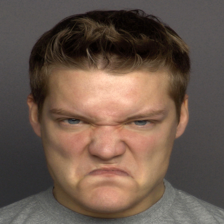

disgust reference:


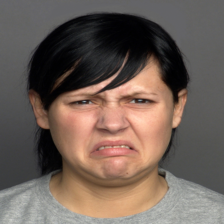

fear reference:


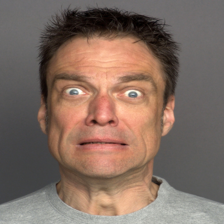

happiness reference:


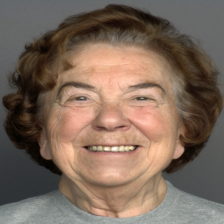

neutral reference:


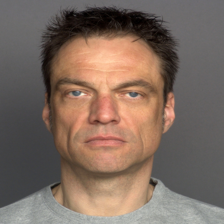

sadness reference:


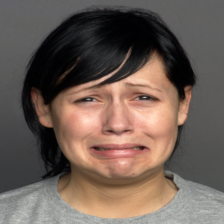

In [14]:
anger = ['anger','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/references/anger/066_y_m_a_a.jpg']

disgust = ['disgust','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/references/disgust/140_y_f_d_a.jpg']

fear = ['fear','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/references/fear/116_m_m_f_a.jpg']

happiness = ['happiness','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/references/happiness/079_o_f_h_a.jpg']

neutral = ['neutral','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/references/neutral/116_m_m_n_a.jpg']

sadness = ['sadness','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/references/sadness/140_y_f_s_a.jpg']

reference_from_ds = [anger,disgust,fear,happiness,neutral,sadness]
for i in range(1,2):
    print('Reference list #{}'.format(i))
    for expression in reference_from_ds:
        print('{} reference:'.format(expression[0]))
        img = default_loader(expression[i])
        img = img.resize((224,224))
        img.show()

In [18]:
#Computing r18 validation presicion on FACESds with references from FACESds
datadir = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/data'
annotation_path = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/annotation_data.txt'
reference_list = reference_from_ds.copy()

file_to_read = open(annotation_path,'r')
annotation_list = [line.split(';') for line in file_to_read.readlines()]
for i in range(1,2):
    expression_reference_logits=[]
    
    for expression_list in reference_list:
        logits_reference = inference(net,expression_list[i])
        logits_reference = np.mean(logits_reference, axis=0)
        logits_reference /= l2norm(logits_reference)
        expression_reference_logits.append((expression_list[0],logits_reference))
        
    overall_corrects = {'anger':0,'sadness':0,'fear':0,'happiness':0,'disgust':0,'neutral':0}
    overall_img_num = {'anger':11,'sadness':11,'fear':11,'happiness':11,'disgust':11,'neutral':11}
    confused_num = 0
    for image in annotation_list:
        label = image[1].replace('\n','')

        logits_val_img = inference(net,image[0])
        logits_val_img = np.mean(logits_val_img, axis=0)
        logits_val_img /= l2norm(logits_val_img)

         
        
        expression_reference_scores=[]
   
        for logits in expression_reference_logits:
            score = np.dot(logits_val_img,logits[1])
            expression_reference_scores.append(score)
                
        max_score = max(expression_reference_scores)
        
        if label == reference_list[expression_reference_scores.index(max_score)][0]:
            overall_corrects[label] += 1
        else:
            confused_num +=1
            img = PIL.Image.open(image[0])
            img = img.save('/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/confused/'+reference[expression_reference_scores.index(max_score)][0]+'/confused'+str(confused_num)+'_when_refered_to_'+str(i)+'.jpg')
        expression_acc = [(key,overall_corrects[key]/overall_img_num[key]) for key in overall_corrects.keys()]
    print(expression_acc)
    print('Confused images number-',confused_num)

[('anger', 0.09090909090909091), ('sadness', 0.36363636363636365), ('fear', 0.5454545454545454), ('happiness', 1.0), ('disgust', 0.45454545454545453), ('neutral', 0.45454545454545453)]
Confused number- 34


In [41]:
#Computing r18 scores the image belongs to GT and saving the image with appropriate name(FACESds)
anger = ['anger','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/references/anger/066_y_m_a_a.jpg']

disgust = ['disgust','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/references/disgust/140_y_f_d_a.jpg']

fear = ['fear','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/references/fear/116_m_m_f_a.jpg']

happiness = ['happiness','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/references/happiness/079_o_f_h_a.jpg']

neutral = ['neutral','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/references/neutral/116_m_m_n_a.jpg']

sadness = ['sadness','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/references/sadness/140_y_f_s_a.jpg']

reference_from_FACESds = [anger,disgust,fear,happiness,neutral,sadness]
 
path2save = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/Scores image belongs to GT/'
datadir = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/data'
annotation_path = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/annotation_data.txt'
reference_list = reference_from_FACESds.copy()

file_to_read = open(annotation_path,'r')
annotation_list = [line.split(';') for line in file_to_read.readlines()]

expression_reference_logits= {'anger':None,'disgust':None,'fear':None,'happiness':None,'neutral':None,'sadness':None}
    
for expression_list in reference_list:
    logits_reference = inference(net,expression_list[i])
    logits_reference = np.mean(logits_reference, axis=0)
    logits_reference /= l2norm(logits_reference)
    expression_reference_logits[expression_list[0]] = logits_reference


for image in annotation_list:

    label = image[1].replace('\n','')
    logits_val_img = inference(net,image[0])
    logits_val_img = np.mean(logits_val_img, axis=0)
    logits_val_img /= l2norm(logits_val_img)
    expression_reference_scores = []
    for logits in expression_reference_logits.values():
        score = np.dot(logits_val_img,logits)
        expression_reference_scores.append(score)        
    max_score = max(expression_reference_scores)
    gt_score = np.dot(logits_val_img,expression_reference_logits[label])
    img = PIL.Image.open(image[0])
    save = img.save(path2save+label+'/'+label+'_gt-score:'+str(gt_score)+'_net-answer:'+reference_list[expression_reference_scores.index(max_score)][0]+'(score:'+str(max_score)+').jpg')
      

"\nfile_to_read = open(annotation_path,'r')\nannotation_list = [line.split(';') for line in file_to_read.readlines()]\n\nexpression_reference_logits= {'anger':None,'disgust':None,'fear':None,'happiness':None,'neutral':None,'sadness':None}\n    \nfor expression_list in reference_list:\n    logits_reference = inference(net,expression_list[i])\n    logits_reference = np.mean(logits_reference, axis=0)\n    logits_reference /= l2norm(logits_reference)\n    expression_reference_logits[expression_list[0]] = logits_reference\n\n\nfor image in annotation_list:\n\n    label = image[1].replace('\n','')\n    logits_val_img = inference(net,image[0])\n    logits_val_img = np.mean(logits_val_img, axis=0)\n    logits_val_img /= l2norm(logits_val_img)\n    expression_reference_scores = []\n    for logits in expression_reference_logits.values():\n        score = np.dot(logits_val_img,logits)\n        expression_reference_scores.append(score)        \n    max_score = max(expression_reference_scores)\n   

In [38]:
#Computing r18 validation presicion on FACESds with references from facesdb
anger = ['anger','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data/s032/bmp/s032-04_img.bmp']

disgust = ['disgust','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data/s013/bmp/s013-05_img.bmp']

fear = ['fear','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data/s032/bmp/s032-06_img.bmp']

happiness = ['happiness','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data/s019/bmp/s019-01_img.bmp']

neutral = ['neutral','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data/s007/bmp/s007-00_img.bmp']

sadness = ['sadness','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data/s028/bmp/s028-02_img.bmp']

surprise = ['surprise','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data/s029/bmp/s029-03_img.bmp']

reference_from_facesdb = [anger,disgust,fear,happiness,neutral,sadness,surprise]
 

datadir = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data'
annotation_path = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data/annotation.txt'
reference_list = reference_from_facesdb.copy()

file_to_read = open(annotation_path,'r')
annotation_list = [line.split(';') for line in file_to_read.readlines()]
for i in range(1,2):
    expression_reference_logits=[]
    
    for expression_list in reference_list:
        logits_reference = inference(net,expression_list[i])
        logits_reference = np.mean(logits_reference, axis=0)
        logits_reference /= l2norm(logits_reference)
        expression_reference_logits.append((expression_list[0],logits_reference))
        
    overall_corrects = {'anger':0,'sadness':0,'fear':0,'happiness':0,'disgust':0,'neutral':0,'surprise':0}
    overall_img_num = {'anger':36,'sadness':36,'fear':36,'happiness':36,'disgust':36,'neutral':36,'surprise':36}
    confused_num = 0
    for image in annotation_list:
        label = image[1]

        logits_val_img = inference(net,image[0])
        logits_val_img = np.mean(logits_val_img, axis=0)
        logits_val_img /= l2norm(logits_val_img)

         
        
        expression_reference_scores=[]
   
        for logits in expression_reference_logits:
            score = np.dot(logits_val_img,logits[1])
            expression_reference_scores.append(score)
                
        max_score = max(expression_reference_scores)
        
        if label == reference_list[expression_reference_scores.index(max_score)][0]:
            overall_corrects[label] += 1
        else:
            confused_num +=1
            #img = PIL.Image.open(image[0])
            #img = img.save('/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/confused/'+reference[expression_reference_scores.index(max_score)][0]+'/confused'+str(confused_num)+'_when_refered_to_'+str(i)+'.jpg')
        expression_acc = [(key,overall_corrects[key]/overall_img_num[key]) for key in overall_corrects.keys()]
    print(expression_acc)
    print('Confused images number-',confused_num)

[('anger', 0.19444444444444445), ('sadness', 0.3888888888888889), ('fear', 0.4722222222222222), ('happiness', 0.08333333333333333), ('disgust', 0.05555555555555555), ('neutral', 0.1388888888888889), ('surprise', 0.1111111111111111)]
Confused images number- 200


In [39]:
#Computing r18 scores the image belongs to GT and saving the image with appropriate name(facesdb)
anger = ['anger','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data/s032/bmp/s032-04_img.bmp']

disgust = ['disgust','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data/s013/bmp/s013-05_img.bmp']

fear = ['fear','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data/s032/bmp/s032-06_img.bmp']

happiness = ['happiness','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data/s019/bmp/s019-01_img.bmp']

neutral = ['neutral','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data/s007/bmp/s007-00_img.bmp']

sadness = ['sadness','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data/s028/bmp/s028-02_img.bmp']

surprise = ['surprise','/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data/s029/bmp/s029-03_img.bmp']

reference_from_ds = [anger,disgust,fear,happiness,neutral,sadness,surprise]
 
path2save = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/Image GT scores/'

datadir = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data'
annotation_path = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data/annotation.txt'
reference_list = reference_from_ds.copy()

file_to_read = open(annotation_path,'r')
annotation_list = [line.split(';') for line in file_to_read.readlines()]

expression_reference_logits= {'anger':None,'disgust':None,'fear':None,'happiness':None,'neutral':None,'sadness':None,'surprise':None}
    
for expression_list in reference_list:
    logits_reference = inference(net,expression_list[1])
    logits_reference = np.mean(logits_reference, axis=0)
    logits_reference /= l2norm(logits_reference)
    expression_reference_logits[expression_list[0]] = logits_reference


for image in annotation_list:

    label = image[1]
    logits_val_img = inference(net,image[0])
    logits_val_img = np.mean(logits_val_img, axis=0)
    logits_val_img /= l2norm(logits_val_img)
    expression_reference_scores = []
    for logits in expression_reference_logits.values():
        score = np.dot(logits_val_img,logits)
        expression_reference_scores.append(score)        
    max_score = max(expression_reference_scores)
    gt_score = np.dot(logits_val_img,expression_reference_logits[label])
    img = PIL.Image.open(image[0])
    save = img.save(path2save+label+'/'+label+'_gt-score:'+str(gt_score)+'_net-answer:'+reference_list[expression_reference_scores.index(max_score)][0]+'(score:'+str(max_score)+').jpg')
        

In [52]:
#r18 Expression identifying within a person expressions(FACESds)
dsdir = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/data/IDs/persons'
reference2path_dict = {'anger':None,'disgust':None,'fear':None,'happiness':None,'neutral':None,'sadness':None}
test2path_dict = {'anger':None,'disgust':None,'fear':None,'happiness':None,'neutral':None,'sadness':None}
reference2logits_dict = {'anger':None,'disgust':None,'fear':None,'happiness':None,'neutral':None,'sadness':None}
test2logits_dict = {'anger':None,'disgust':None,'fear':None,'happiness':None,'neutral':None,'sadness':None}

for person in os.listdir(dsdir):

    for mode in os.listdir(os.path.join(dsdir,person)):        
        for expression in os.listdir(os.path.join(dsdir,person,mode)):
            if mode == 'a':
                reference2path_dict[expression] = os.path.join(dsdir,person,mode,expression,os.listdir(os.path.join(dsdir,person,mode,expression))[0])
                try:
                    reference2logits_dict[expression] = inference(net,reference2path_dict[expression])
                    reference2logits_dict[expression] = np.mean(reference2logits_dict[expression], axis=0)
                    reference2logits_dict[expression] /= l2norm(reference2logits_dict[expression])
                except:
                    print(reference2path_dict[expression])

            if mode == 'b':
                test2path_dict[expression] = os.path.join(dsdir,person,mode,expression,os.listdir(os.path.join(dsdir,person,mode,expression))[0])
                test2logits_dict[expression] = inference(net,test2path_dict[expression])
                test2logits_dict[expression] = np.mean(test2logits_dict[expression], axis=0)
                test2logits_dict[expression] /= l2norm(test2logits_dict[expression])
    for test_expression in test2path_dict.keys():
        test_reference_score_dict = {'anger':None,'disgust':None,'fear':None,'happiness':None,'neutral':None,'sadness':None}
        for reference_exoression in reference2path_dict.keys():
            test_reference_score_dict[reference_exoression] = np.dot(reference2logits_dict[reference_exoression],test2logits_dict[test_expression])
        net_answer = max(test_reference_score_dict,key = test_reference_score_dict.get)
        gt_score = test_reference_score_dict[test_expression]
        img = PIL.Image.open(test2path_dict[test_expression])
        img = img.save(os.path.join('/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/data/IDs/image GT scores',person,test_expression+'_gt_score:'+str(gt_score)+'_net-answer:'+net_answer+'(score:'+str(test_reference_score_dict[net_answer])+').jpg'))
    
    
                    

In [59]:
#r18 Expression identifying within a person expressions(facesdb)
dsdir = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/data'
reference2path_dict = {'anger':None,'disgust':None,'fear':None,'happiness':None,'neutral':None,'sadness':None}
test2path_dict = {'anger':None,'disgust':None,'fear':None,'happiness':None,'neutral':None,'sadness':None}
reference2logits_dict = {'anger':None,'disgust':None,'fear':None,'happiness':None,'neutral':None,'sadness':None}
test2logits_dict = {'anger':None,'disgust':None,'fear':None,'happiness':None,'neutral':None,'sadness':None}
expression_dict = {'4':'anger','5':'disgust','6':'fear','1':'happiness','0':'neutral','2':'sadness','3':'surprise'}
person_folder = os.listdir(dsdir)
person_folder.remove('annotation.txt')
person_folder.remove('fen.txt')
person_folder.remove('.ipynb_checkpoints')
for person in person_folder:
      
    for expression in os.listdir(os.path.join(dsdir,person,'bmp')):
     
        reference2path_dict[expression_dict[expression[6]]] = os.path.join(dsdir,person,'bmp',expression)
        try:
            reference2logits_dict[expression_dict[expression[6]]] = inference(net,reference2path_dict[expression_dict[expression[6]]])
            reference2logits_dict[expression_dict[expression[6]]] = np.mean(reference2logits_dict[expression_dict[expression[6]]], axis=0)
            reference2logits_dict[expression_dict[expression[6]]] /= l2norm(reference2logits_dict[expression_dict[expression[6]]])
        except:
            print(reference2path_dict[expression_dict[expression[6]]])

     
        test2path_dict[expression_dict[expression[6]]] = os.path.join(dsdir,person,'bmp',expression)
        test2logits_dict[expression_dict[expression[6]]] = inference(net,test2path_dict[expression_dict[expression[6]]])
        test2logits_dict[expression_dict[expression[6]]] = np.mean(test2logits_dict[expression_dict[expression[6]]], axis=0)
        test2logits_dict[expression_dict[expression[6]]] /= l2norm(test2logits_dict[expression_dict[expression[6]]])
    os.mkdir(os.path.join('/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/ID reference-ID GT score',person))
    for test_expression in test2path_dict.keys():
        test_reference_score_dict = {'anger':None,'disgust':None,'fear':None,'happiness':None,'neutral':None,'sadness':None}
        for reference_exoression in reference2path_dict.keys():
            test_reference_score_dict[reference_exoression] = np.dot(reference2logits_dict[reference_exoression],test2logits_dict[test_expression])
        net_answer = max(test_reference_score_dict,key = test_reference_score_dict.get)
        gt_score = test_reference_score_dict[test_expression]
        img = PIL.Image.open(test2path_dict[test_expression])
        
        img = img.save(os.path.join('/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/facesdb/ID reference-ID GT score',person,test_expression+'_gt_score:'+str(gt_score)+'_net-answer:'+net_answer+'(score:'+str(test_reference_score_dict[net_answer])+').jpg'))
    
  

## Next goes the section where the same validation procedure with the same reference sets and val sets is implemented, but for resnet34

In [2]:
sys.path.append('/storage_labs/3030/BelyakovM/Face_attributes/insightface/recognition/arcface_torch')
from backbones import get_model
net = get_model('r34', fp16=False)
net.load_state_dict(torch.load('/storage_labs/3030/BelyakovM/Face_attributes/insightface/recognition/arcface_torch/work_dirs_r34/AffectnetOzon_r34/backbone_37.pth'))
@torch.no_grad()
def inference(net, img):
    if img is None:
        img = np.random.randint(0, 255, size=(112, 112, 3), dtype=np.uint8)
    else:
        img = cv2.imread(img)
        img = cv2.resize(img, (112, 112))

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.transpose(img, (2, 0, 1))
    img = torch.from_numpy(img).unsqueeze(0).float()
    img.div_(255).sub_(0.5).div_(0.5)
 
    net.eval()
    feat = net(img).numpy()
    return feat

In [7]:
#Computing r34 validation accuracy on Affect/val set with external references 
datadir = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/AffecetNet_partly/original/val'
for i in range(1,4):
    expression_reference_logits=[]
    for expression_list in reference:
        logits_reference = inference(net,'/storage_labs/3030/BelyakovM/'+expression_list[i])
        logits_reference = np.mean(logits_reference, axis=0)
        logits_reference /= l2norm(logits_reference)
        expression_reference_logits.append((expression_list[0],logits_reference))
    folder_acc=[]
    for folder in os.listdir(datadir):
        folder_corrects = 0
        imgs = os.listdir(os.path.join(datadir,folder))
        num_folder_imgs = len(imgs)
        for image in imgs:
            try:
                logits_val_img = inference(net,os.path.join(datadir,folder,image))
                logits_val_img = np.mean(logits_val_img, axis=0)
                logits_val_img /= l2norm(logits_val_img)
            except:
                num_folder_imgs -= 1
                continue
            expression_reference_scores=[]
   
            for logits in expression_reference_logits:
                score = np.dot(logits_val_img,logits[1])
                expression_reference_scores.append(score)
                
            max_score = max(expression_reference_scores)
            if folder == reference[expression_reference_scores.index(max_score)][0]:
                folder_corrects += 1
        folder_acc.append((folder,folder_corrects/num_folder_imgs))
    print(folder_acc)

[('anger', 0.47), ('sadness', 0.668), ('fear', 0.73), ('happiness', 0.772), ('surprise', 0.66), ('disgust', 0.556), ('neutral', 0.52)]
[('anger', 0.11), ('sadness', 0.61), ('fear', 0.57), ('happiness', 0.78), ('surprise', 0.526), ('disgust', 0.746), ('neutral', 0.528)]
[('anger', 0.604), ('sadness', 0.56), ('fear', 0.758), ('happiness', 0.752), ('surprise', 0.678), ('disgust', 0.688), ('neutral', 0.564)]


In [5]:
#Computing r34 validation accuracy on OZON/val set with external references 
datadir = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/OZON_splited/val'
for i in range(1,4):
    expression_reference_logits=[]
    for expression_list in reference:
        logits_reference = inference(net,'/storage_labs/3030/BelyakovM/'+expression_list[i])
        logits_reference = np.mean(logits_reference, axis=0)
        logits_reference /= l2norm(logits_reference)
        expression_reference_logits.append((expression_list[0],logits_reference))
    folder_acc=[]
    folders = os.listdir(datadir)
    folders.sort()
    for folder in folders:
        if folder == '.ipynb_checkpoints':
            continue
        folder_corrects = 0
        imgs = os.listdir(os.path.join(datadir,folder))
        num_folder_imgs = len(imgs)
        for image in imgs:
            try:
                logits_val_img = inference(net,os.path.join(datadir,folder,image))
                logits_val_img = np.mean(logits_val_img, axis=0)
                logits_val_img /= l2norm(logits_val_img)
            except:
                num_folder_imgs -= 1
                continue
            expression_reference_scores=[]
   
            for logits in expression_reference_logits:
                score = np.dot(logits_val_img,logits[1])
                expression_reference_scores.append(score)
                
            max_score = max(expression_reference_scores)
            if folder == reference[expression_reference_scores.index(max_score)][0]:
                folder_corrects += 1
        folder_acc.append((folder,folder_corrects/num_folder_imgs))
    print(folder_acc)

[('anger', 0.39501779359430605), ('disgust', 0.277337559429477), ('fear', 0.44400396432111), ('happiness', 0.7321578505457599), ('neutral', 0.46799116997792495), ('sadness', 0.5786350148367952), ('surprise', 0.5320158102766799)]
[('anger', 0.08967971530249111), ('disgust', 0.4009508716323296), ('fear', 0.42021803766105054), ('happiness', 0.7405541561712846), ('neutral', 0.5320088300220751), ('sadness', 0.4903560830860534), ('surprise', 0.38814229249011856)]
[('anger', 0.5330960854092527), ('disgust', 0.30427892234548337), ('fear', 0.5203171456888008), ('happiness', 0.7220822837951302), ('neutral', 0.5268579838116262), ('sadness', 0.43397626112759646), ('surprise', 0.5312252964426878)]


In [8]:
#r34 Expression identifying within a person expressions(FACESds)
dsdir = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/data/IDs/persons'
reference2path_dict = {'anger':None,'disgust':None,'fear':None,'happiness':None,'neutral':None,'sadness':None}
test2path_dict = {'anger':None,'disgust':None,'fear':None,'happiness':None,'neutral':None,'sadness':None}
reference2logits_dict = {'anger':None,'disgust':None,'fear':None,'happiness':None,'neutral':None,'sadness':None}
test2logits_dict = {'anger':None,'disgust':None,'fear':None,'happiness':None,'neutral':None,'sadness':None}

for person in os.listdir(dsdir):

    for mode in os.listdir(os.path.join(dsdir,person)):        
        for expression in os.listdir(os.path.join(dsdir,person,mode)):
            if mode == 'a':
                reference2path_dict[expression] = os.path.join(dsdir,person,mode,expression,os.listdir(os.path.join(dsdir,person,mode,expression))[0])
                try:
                    reference2logits_dict[expression] = inference(net,reference2path_dict[expression])
                    reference2logits_dict[expression] = np.mean(reference2logits_dict[expression], axis=0)
                    reference2logits_dict[expression] /= l2norm(reference2logits_dict[expression])
                except:
                    print(reference2path_dict[expression])

            if mode == 'b':
                test2path_dict[expression] = os.path.join(dsdir,person,mode,expression,os.listdir(os.path.join(dsdir,person,mode,expression))[0])
                test2logits_dict[expression] = inference(net,test2path_dict[expression])
                test2logits_dict[expression] = np.mean(test2logits_dict[expression], axis=0)
                test2logits_dict[expression] /= l2norm(test2logits_dict[expression])
    for test_expression in test2path_dict.keys():
        test_reference_score_dict = {'anger':None,'disgust':None,'fear':None,'happiness':None,'neutral':None,'sadness':None}
        for reference_exoression in reference2path_dict.keys():
            test_reference_score_dict[reference_exoression] = np.dot(reference2logits_dict[reference_exoression],test2logits_dict[test_expression])
        net_answer = max(test_reference_score_dict,key = test_reference_score_dict.get)
        gt_score = test_reference_score_dict[test_expression]
        img = PIL.Image.open(test2path_dict[test_expression])
        img = img.save(os.path.join('/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/FACESds_copy/data/IDs/image GT scores/r34',person,test_expression+'_gt_score:'+str(gt_score)+'_net-answer:'+net_answer+'(score:'+str(test_reference_score_dict[net_answer])+').jpg'))
    
    

In [5]:
#Treshhold computing
datadir = '/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/AffecetNet_partly/original/val'
file_to_write = open('/storage_labs/3030/BelyakovM/Face_attributes/ds/db_BuevichP/emochon/AffecetNet_partly/original/Treshhold_val','w+')
expression_reference_logits=[]
express2indx = {'anger':0,'disgust':1,'fear':2,'happiness':3,'neutral':4,'sadness':5,'surprise':6}
for i in range(1,4):
    for expression_list in reference:
        logits_reference = inference(net,'/storage_labs/3030/BelyakovM/'+expression_list[i])
        logits_reference = np.mean(logits_reference, axis=0)
        logits_reference /= l2norm(logits_reference)
        expression_reference_logits.append((expression_list[0],logits_reference))

    expression_reference_mean_scores = {'anger':0,'sadness':0,'fear':0,'happiness':0,'disgust':0,'neutral':0,'surprise':0}
    for expression in os.listdir(datadir):
        imgs_list = os.listdir(os.path.join(datadir,expression))
        num_folder_imgs = len(imgs_list)
        for image in imgs_list:
            try: 
                logits_val_img = inference(net,os.path.join(datadir,expression,image))
                logits_val_img = np.mean(logits_val_img, axis=0)
                logits_val_img /= l2norm(logits_val_img)
            except:
                num_folder_imgs -= 1
                continue
        
        
            score = np.dot(logits_val_img,expression_reference_logits[express2indx[expression]][1])
            expression_reference_mean_scores[expression] += score
        expression_reference_mean_scores[expression] /= num_folder_imgs
    
    print(expression_reference_mean_scores)

{'anger': -0.06331270580366254, 'sadness': 0.5369452998414636, 'fear': 0.6019274449823424, 'happiness': 0.7104119304791093, 'disgust': 0.6149329068101943, 'neutral': 0.4224602678231895, 'surprise': 0.4736080201137811}
{'anger': -0.06331270580366254, 'sadness': 0.5369452998414636, 'fear': 0.6019274449823424, 'happiness': 0.7104119304791093, 'disgust': 0.6149329068101943, 'neutral': 0.4224602678231895, 'surprise': 0.4736080201137811}
{'anger': -0.06331270580366254, 'sadness': 0.5369452998414636, 'fear': 0.6019274449823424, 'happiness': 0.7104119304791093, 'disgust': 0.6149329068101943, 'neutral': 0.4224602678231895, 'surprise': 0.4736080201137811}
